Hunter Bennett  
Christopher K Glass Laboratory  
Created 20171212 | Last updated 20171212
_____

Analyze ATAC seq data in strains

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import subprocess
import os
import sys
import glob
import re

# import user defined packages
sys.path.insert(0, '/home/h1bennet/scripts')
import hbUtils

# plot matplotlib plots in notebook
%matplotlib inline

In [4]:
# define path to data
datapath = {'kupffer':'/data/mm10/Kupffer/ATAC/'}

# define output directory
outdir = '/home/h1bennet/liverStrains/results/171212_ATAC/'
if not os.path.isdir(outdir):
    subprocess.call(['mkdir', outdir])

# define samples for both whole liver and kupffer
samples = {'kupffer':["aj_Kupffer_ATAC_AMLNDiet_30week_AJ3A_JSS_TDT_16_09_26",
"aj_Kupffer_ATAC_AMLNDiet_30week_AJ3B_JSS_TDT_16_09_26",
"aj_Kupffer_ATAC_ControlDiet_30week_AJ1B_JSS_TDT_16_09_26",
"aj_Kupffer_ATAC_ControlDiet_30week_AJ1C_JSS_TDT_16_09_28",
"balbc_Kupffer_ATAC_AMLNDiet_30week_Balb3C_JSS_TDT_16_09_26",
"balbc_Kupffer_ATAC_AMLNDiet_30week_Balb3D_JSS_TDT_16_09_28",
"balbc_Kupffer_ATAC_ControlDiet_30week_Balb1A_JSS_TDT_16_09_26",
"balbc_Kupffer_ATAC_ControlDiet_30week_Balb1B_JSS_TDT_16_09_26",
"NCoRWT_KupfferTotal_ATAC_AMLNDiet_30week_LN136C_JSS_TDT_16_09_19",
"NCoRWT_KupfferTotal_ATAC_AMLNDiet_30week_LN141A_JSS_TDT_16_09_21",
"NCoRWT_KupfferTotal_ATAC_ControlDiet_30week_LN134B_JSS_TDT_16_09_21",
"NCoRWT_KupfferTotal_ATAC_ControlDiet_30week_LN134D_JSS_TDT_16_09_21"]}

bad_samples = {'LN140D': 'cancer', 'LN136B': 'cancer', 'LN148B': 'cancer',
              'LN144A': 'cancer', 'LN144C': 'cancer', 'LN182B': 'cancer',
              'LN182B': 'cancer', 'LN203B': 'cancer', 'BALB3A': 'splenomegaly',
              'BALB4D': 'hyper-fibrosis', 'LN148B': 'cancer', 'LN166A': 'cancer'}

In [207]:
# user defined functions
def merge_peaks(dir1, dir2, outdir, dist='given', print_err=False):
    import subprocess
    import os
    # make output directory if necessary
    if not os.path.isdir(outdir): subprocess.call(["mkdir", outdir])
    # construct function call
    mP_call = ["mergePeaks"]
    mP_call.extend(['-d', dist])
    mP_call.extend([dir1 + '/optimal_peakfile.txt',
                    dir2 + '/optimal_peakfile.txt'])
    # call merge peaks
    if not os.path.isfile(outdir + '/optimal_peakfile_merge.txt'):
        p = subprocess.Popen(mP_call,
                            stdout = subprocess.PIPE,
                            stderr = subprocess.PIPE)
        output, err = p.communicate() #in bytes
        if print_err: print(err.decode('utf-8'))
        f = open(outdir + '/optimal_peakfile_merge.txt', 'w')
        f.write(output.decode("utf-8"))
        f.close()
    else: print('merge peaks file ' + outdir + '/optimal_peakfile_merge.txt already exists!')
    return outdir + '/optimal_peakfile_merge.txt'

def anno_peaks(dir1, dir2, outdir, dist='given', print_err=False):
    import subprocess
    import os
    # call merge peaks
    mPPath = merge_peaks(dir1, dir2, outdir)
    # construct function call
    aPCallList = ['annotatePeaks.pl', mPPath, 'mm10', '-d']
    aPCallList.extend([dir1 + '/pooled_tag_dirs', dir2 + '/pooled_tag_dirs'])
    # call annotate peaks
    aPPath = mPPath.replace('.txt', '_anno.txt')
    if not os.path.isfile(aPPath):
        p = subprocess.Popen(aPCallList,
                         stdout=subprocess.PIPE,
                         stderr=subprocess.PIPE)
        output, err = p.communicate()
        if print_err: print(err.decode('utf-8'))
        #write output
        f = open(aPPath, 'w')
        f.write(output.decode("utf-8"))
        f.close()
    else: print('annotate peaks file: ' + aPPath + ' already exists!')
    return aPPath

def diff_peaks(dir1, dir2, outdir, rev=False, print_err=False):
    import subprocess
    import os
    # make output directory if necessary
    if not os.path.isdir(outdir): subprocess.call(["mkdir", outdir])
    # call merge peaks
    mPPath = merge_peaks(dir1, dir2, outdir)
    # create differential peaks all
    gDPCall = ["getDifferentialPeaks", mPPath,
                        dir1 + "/pooled_tag_dirs",
                        dir2 + "/pooled_tag_dirs"]
    # adjust if it will call reverse peaks against background
    if rev:
        gDPCall.append("-rev")
        dPPath = outdir + '/diffpeaks_rev.txt'
    else:
        dPPath = outdir + '/diffpeaks.txt'
    # call differential peaks
    if not os.path.isfile(dPPath):
        p = subprocess.Popen(gDPCall,
                        stdout = subprocess.PIPE,
                        stderr = subprocess.PIPE)
        output, err = p.communicate() #in bytes
        if print_err: print(err.decode('utf-8'))
        # print output
        f = open(dPPath, 'w')
        f.write(output.decode("utf-8"))
        f.close()
    else: print('diff peaks file: ' + dPPath + ' already exists!')
    return dPPath

def call_homer(peakfile, genome, outdir, size = 200):
    import subprocess
    import os

    if not os.path.isdir(outdir):
        subprocess.call(["mkdir", outdir])
        
    homerCall = ["findMotifsGenome.pl", peakfile, genome, outdir, "-size", "200"]
    p = subprocess.call(homerCall)
    
def clean_sample_IDs(idList):
    import re
    p = re.compile('C57[\w]{0,3}_', re.IGNORECASE)
    tmp = [i.replace("-", "_").strip("mouse_") for i in idList]
    tmp = [p.sub(i, "C57BL6_", re.I) for i in tmp]
    cleanIdList = []
    for i in tmp:
        idParts = i.split("_")
        idParts[0] = idParts[0].upper()
        cleanIdList.append("_".join(idParts))
    return cleanIdList

def run_atac_diff_peaks(dir1, dir2, outdir):
    '''Compare the peaks from dir1 and dir1, output basic graphs and a
    pandas data frame with annotations and differential peaks marked.
    
    takes the full path to the directories and output directory
    '''
    import subprocess
    import os
    import pandas
    
    if not os.path.isdir(outdir):
        subprocess.call(["mkdir", outdir])
    samples= [dir1.split('/')[-1], dir2.split('/')[-1]]
    ## Call anno peaks ##
    aPPath = anno_peaks(dir1, dir2, outdir)
    ## Get diff peaks ##
    dPPath = diff_peaks(dir1, dir2, outdir)
    dP = read_diff_peak_file(dPPath)
    dPPathRev = diff_peaks(dir1, dir2, outdir, rev = True)
    dPRev = read_diff_peak_file(dPPathRev)
    # we will plot with out main peak file
    peaks = pd.read_csv(aPPath, sep='\t', comment=None)
    sample_cols = list(peaks.columns.values[-2:])
    peaks.columns.values[0] = 'PeakID'
    # Annotate main peaks file with whether peaks are differential
    peaks.loc[:,'diffPeak'] = ['nonsig'] * peaks.shape[0]
    peaks.loc[peaks.iloc[:, 0].str.contains('|'.join(dP.iloc[:, 0])), 'diffPeak'] = 'up'
    peaks.loc[peaks.iloc[:, 0].str.contains('|'.join(dPRev.iloc[:, 0])), 'diffPeak'] = 'dn'

    # add log2 scale for counts for plotting
    peaks.loc[:, 'log2'+samples[0]] = np.log2(peaks.loc[:, sample_cols[0]] + 1)
    peaks.loc[:, 'log2'+samples[1]] = np.log2(peaks.loc[:, sample_cols[1]] + 1)
    f = sns.lmplot(x='log2'+samples[0],
           y='log2'+samples[1],
           data=peaks,
           fit_reg=False,
           hue='diffPeak',
           size=8)
    plt.title('Shared ATAC Peaks')
    
    return (peaks, dP, dPRev)

def read_diff_peak_file(dppath, nSkip=18):
    import pandas as pd
    from pandas.parser import CParserError
    
    try:
        dP = pd.read_csv(dppath, sep = '\t', skiprows = nSkip, comment=None)
        return dP
    except CParserError:
        print('skipped incorrect number of lines, check input file')
        return None
    return None

In [38]:
# define sample data frame
samplesDF = pd.DataFrame([s for groups in samples.values() for s in groups], columns = ['subject'])
samplesDF['sample_type'] = ['liver' if 'WholeLiver' in name else 'kupffer' for name in samplesDF.subject]
samplesDF['path'] = [datapath[key] + s for key in datapath.keys() for s in samples[key]]
samplesDF['batch'] = pd.factorize(samplesDF.subject\
             .str.replace('-','_')\
             .str.findall(r'(\d+_\d+_\d+)').str[0])[0]
samplesDF['strain'] = [j.replace('-', '_').split('_')[0].lower() for j in samplesDF.subject]
samplesDF['diet'] = ['amln' if 'AMLN' in name else 'control' for name in samplesDF.subject]
samplesDF['group'] = samplesDF.strain + '_' + samplesDF.diet
samplesDF['group_tissue'] = samplesDF.strain + '_' + samplesDF.diet + '_' + samplesDF.sample_type
samplesDF['exclusion'] = samplesDF.subject.str.contains('|'.join(bad_samples.keys()),
                                                       flags=re.IGNORECASE)

In [7]:
# set colors for the samples
color_dict = {'aj-control':'#fb9a99', 'aj-amln':'#e31a1c',
              'balbc-control':'#a6cee3', 'balbc-amln':'#1f78b4',
              'ncorwt-control':'#b2df8a', 'ncorwt-amln':'#33a02c'}
color_dict_tissue = {'aj-control-kupffer':'#fb9a99', 'aj-amln-kupffer':'#e31a1c',
            'balbc-control-kupffer':'#a6cee3', 'balbc-amln-kupffer':'#1f78b4',
            'ncorwt-control-kupffer':'#b2df8a', 'ncorwt-amln-kupffer':'#33a02c',
            'aj-control-liver':'#fdae6b', 'aj-amln-liver':'#e6550d',
            'balbc-control-liver':'#bcbddc', 'balbc-amln-liver':'#756bb1',
            'ncorwt-control-liver':'#bdbdbd', 'ncorwt-amln-liver':'#737373'}
samplesDF['color'] = [color_dict[group] for group in samplesDF.group]

# write out samplesDF
samplesDF.to_csv(outdir + 'amln_samples.txt', sep='\t')

In [11]:
for i in samplesDF.group.unique():
    analysis = i.replace('-', '_')
    print('analyzing ' + analysis)
    tmp = samplesDF[samplesDF.group == i]
    
    if not (os.path.isdir(outdir + analysis) & os.path.isfile(outdir + analysis + '/optimal_peakfile.txt')):
        #Run IDR with wrapper from Verena
        perlCallList = ['perl', '/home/h1bennet/liverStrains/bin/run_IDR.pl', '-tag_dirs']
        perlCallList.extend(tmp.path)
        perlCallList.extend(['-output_dir', outdir + analysis, '-method', 'atac'])
        subprocess.call(perlCallList)
    
    if not os.path.isfile(outdir + analysis + '/optimal_peakfileAnno.txt'):
        #Run Annotate peaks
        aPCallList = ['annotatePeaks.pl', outdir + analysis + '/optimal_peakfile.txt', 'mm10', '-d']
        aPCallList.extend(tmp.path)
        p = subprocess.Popen(aPCallList, stdout = subprocess.PIPE)
        output = p.stdout.read()
        f = open(outdir + analysis + '/optimal_peakfileAnno.txt', 'w')
        f.write(output.decode("utf-8"))
        f.close()

analyzing aj_amln
analyzing aj_control
analyzing balbc_amln
analyzing balbc_control
analyzing ncorwt_amln
analyzing ncorwt_control


Lets plot the pairwise replicates of IDR peaks

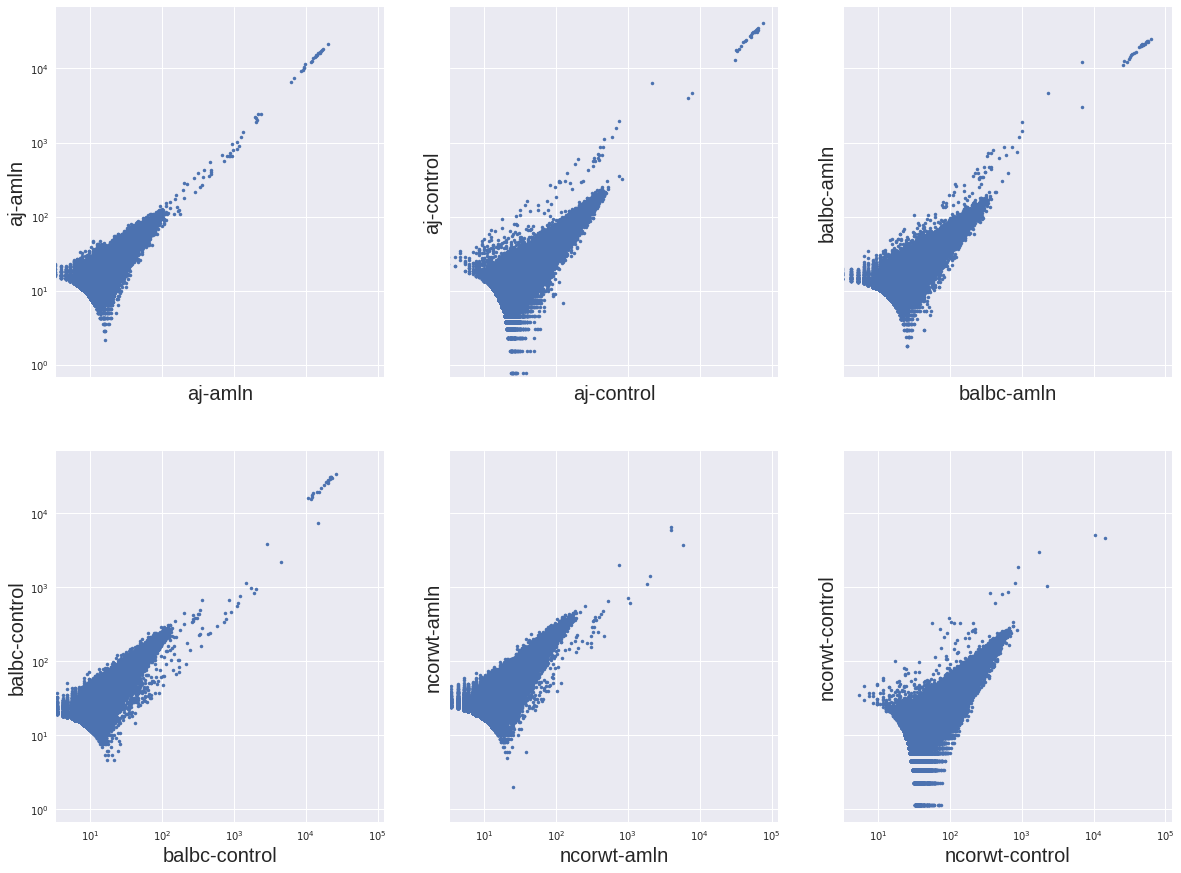

In [36]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,15),sharex=True, sharey=True)
for ax, i in zip(axs.reshape(-1), samplesDF.group.unique()):
    analysis = i.replace('-', '_')
    aP = outdir + analysis + '/optimal_peakfileAnno.txt'
    optPeaks = pd.read_csv(aP, sep='\t')
    ax.loglog(optPeaks.iloc[:, -2], optPeaks.iloc[:, -1], '.')
    ax.set_xlabel(i, fontsize=20)
    ax.set_ylabel(i, fontsize=20)

Start with analysis of balb peaks

merge peaks file /home/h1bennet/liverStrains/results/171212_ATAC/balbc_amln/optimal_peakfile_merge.txt already exists!
annotate peaks file: /home/h1bennet/liverStrains/results/171212_ATAC/balbc_amln/optimal_peakfile_merge_anno.txt already exists!
merge peaks file /home/h1bennet/liverStrains/results/171212_ATAC/balbc_amln/optimal_peakfile_merge.txt already exists!
diff peaks file: /home/h1bennet/liverStrains/results/171212_ATAC/balbc_amln/diffpeaks.txt already exists!
merge peaks file /home/h1bennet/liverStrains/results/171212_ATAC/balbc_amln/optimal_peakfile_merge.txt already exists!
diff peaks file: /home/h1bennet/liverStrains/results/171212_ATAC/balbc_amln/diffpeaks_rev.txt already exists!


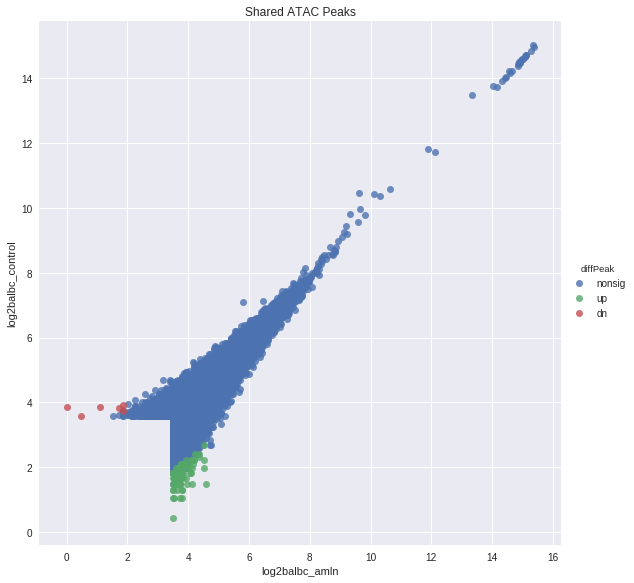

In [209]:
(peaks, dP, dPRev) = run_atac_diff_peaks(amln_dir, control_dir, outdir + 'balbc_amln')

merge peaks file /home/h1bennet/liverStrains/results/171212_ATAC/aj_amln/optimal_peakfile_merge.txt already exists!
merge peaks file /home/h1bennet/liverStrains/results/171212_ATAC/aj_amln/optimal_peakfile_merge.txt already exists!


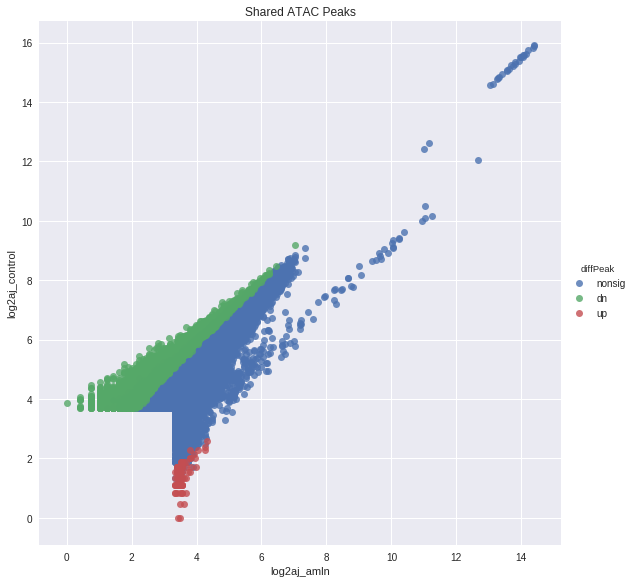

In [210]:
(peaks, dP, dPRev) = run_atac_diff_peaks(outdir + 'aj_amln', outdir + 'aj_control', outdir + 'aj_amln')

merge peaks file /home/h1bennet/liverStrains/results/171212_ATAC/ncorwt_amln/optimal_peakfile_merge.txt already exists!
merge peaks file /home/h1bennet/liverStrains/results/171212_ATAC/ncorwt_amln/optimal_peakfile_merge.txt already exists!


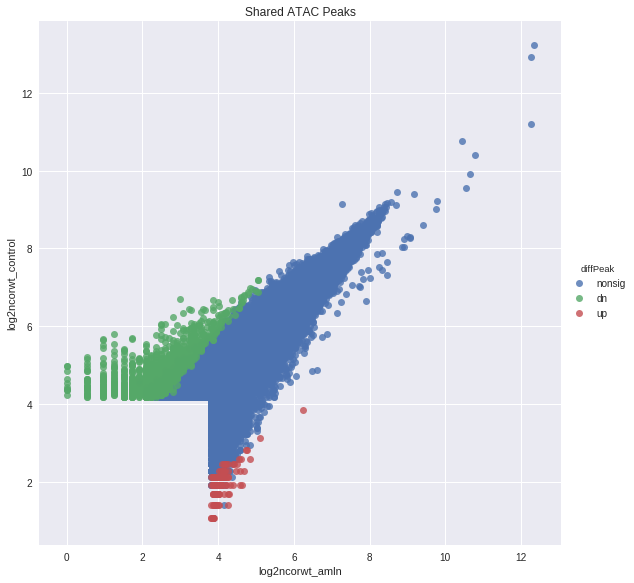

In [211]:
(peaks, dP, dPRev) = run_atac_diff_peaks(outdir + 'ncorwt_amln', outdir + 'ncorwt_control', outdir + 'ncorwt_amln')